### Setup

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [93]:
import pandas as pd
from IPython.display import display 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import os
import seaborn as sns
from datetime import datetime


### Creating datapaths

In [94]:
path= r"G:\Meu Drive\Meu projeto\csv_analise\top\neutro\Fidel_Obj.Neutro(lata)_11_06_25DLC_Resnet50_top_viewMay29shuffle1_snapshot_110.csv"
df = pd.read_csv(path, header=[1, 2])

video_path = r"G:\Meu Drive\Meu projeto\csv_analise\top\neutro\Fidel_Obj.Neutro(lata)_11_06_25_1.mp4"
cap = cv2.VideoCapture(video_path) 

### Box area selection

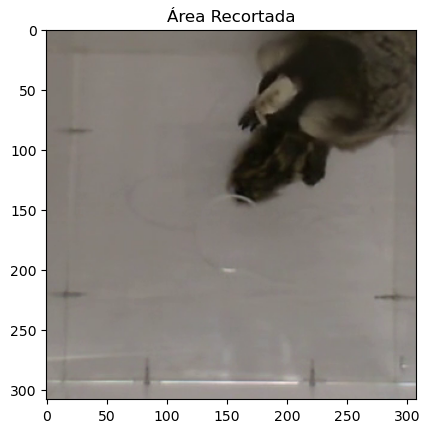

In [95]:
cap = cv2.VideoCapture(video_path) 
numOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
chosenFrameIdx = np.random.randint(1, high=numOfFrames)
cap.set(cv2.CAP_PROP_POS_FRAMES, chosenFrameIdx)
res, chosenFrame = cap.read()

original_height, original_width, _ = chosenFrame.shape
display_max_width = 700
ratio = display_max_width / original_width
display_height = int(original_height * ratio)

frame_for_selection = cv2.resize(chosenFrame, (display_max_width, display_height))

roi_small = cv2.selectROI('Select the arena, then press space and enter', frame_for_selection) 

x_scale = original_width / display_max_width
y_scale = original_height / display_height

roi_original_scale = (
    int(roi_small[0] * x_scale),
    int(roi_small[1] * y_scale),
    int(roi_small[2] * x_scale),
    int(roi_small[3] * y_scale)
)

roi_cropped = chosenFrame[int(roi_original_scale[1]):int(roi_original_scale[1]+roi_original_scale[3]), int(roi_original_scale[0]):int(roi_original_scale[0]+roi_original_scale[2])]
plt.imshow(cv2.cvtColor(roi_cropped, cv2.COLOR_BGR2RGB))
plt.title("Área Recortada")
plt.show()

cv2.waitKey(0) 
cv2.destroyAllWindows()

arenaSide = (roi_original_scale[2] + roi_original_scale[3]) / 2 
xThresholdLeft = roi_original_scale[0]
xThresholdRight = roi_original_scale[0] + arenaSide
yThresholdUp = roi_original_scale[1]
yThresholdDown = roi_original_scale[1] + arenaSide

### Convert pixel to cm

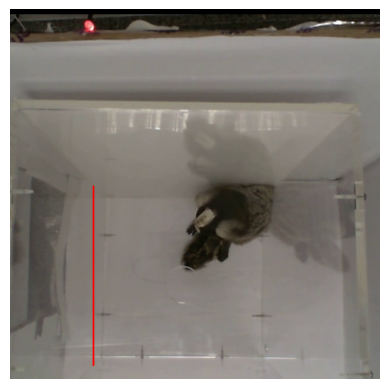

Pixels per cm: 11.846153846153847


In [96]:
py1 = yThresholdDown 
py2 = yThresholdUp
px = xThresholdLeft

frame_with_line = chosenFrame.copy()
cv2.line(frame_with_line, (px, int(py1)), (px, int(py2)), (0, 0, 255), 2)  
frame_with_line_rgb = cv2.cvtColor(frame_with_line, cv2.COLOR_BGR2RGB)
plt.imshow(frame_with_line_rgb)
plt.axis('off') 
plt.show()

pix_per_cm = (py1-py2) / 26 # 26 cm é a distância entre os dois pontos
print(f"Pixels per cm: {pix_per_cm}")

### Filter coordinates

In [97]:
head_x = df[('head', 'x')].values
head_y = df[('head', 'y')].values
nose_x = df[('nose', 'x')].values
nose_y = df[('nose', 'y')].values

head_x_filt = np.where((head_x >= xThresholdLeft) & (head_x <= xThresholdRight), head_x, np.nan)
head_y_filt = np.where((head_y >= yThresholdUp) & (head_y <= yThresholdDown), head_y, np.nan)
nose_x_filt = np.where((nose_x >= xThresholdLeft) & (nose_x <= xThresholdRight), nose_x, np.nan)
nose_y_filt = np.where((nose_y >= yThresholdUp) & (nose_y <= yThresholdDown), nose_y, np.nan)

head_x_cm = head_x_filt  / pix_per_cm
head_y_cm = head_y_filt  / pix_per_cm
nose_x_cm = nose_x_filt  / pix_per_cm
nose_y_cm = nose_y_filt  / pix_per_cm

mask = ~np.isnan(head_x_cm) & ~np.isnan(head_y_cm)
head_x = head_x_cm[mask]
head_y = head_y_cm[mask]
nose_x = nose_x_cm[mask]
nose_y = nose_y_cm[mask]

head_x = pd.Series(head_x).rolling(window=59, min_periods=1, center=True).mean().values
head_y = pd.Series(head_y).rolling(window=59, min_periods=1, center=True).mean().values
nose_x = pd.Series(nose_x).rolling(window=59, min_periods=1, center=True).mean().values
nose_y = pd.Series(nose_y).rolling(window=59, min_periods=1, center=True).mean().values

### Angular coordinates

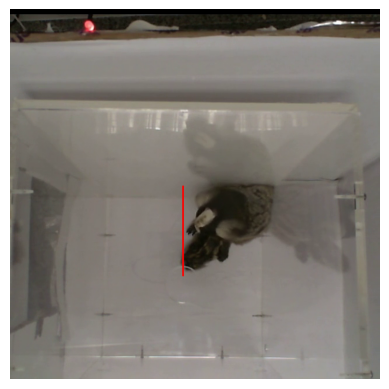

In [98]:
mid_x=((xThresholdRight - xThresholdLeft) / 2) + xThresholdLeft
mid_y=((yThresholdDown - yThresholdUp) / 2) + yThresholdUp

py1 = int(mid_y)
py2 = yThresholdUp
px = int(mid_x)

frame_with_line = chosenFrame.copy()
cv2.line(frame_with_line, (px, int(py1)), (px, int(py2)), (0, 0, 255), 2)  
frame_with_line_rgb = cv2.cvtColor(frame_with_line, cv2.COLOR_BGR2RGB)
plt.imshow(frame_with_line_rgb)
plt.axis('off') 
plt.show()


In [89]:
# Vetor de referência: linha vertical de (px, py1) até (px, py2)
ref_dx = 0
ref_dy = py2 - py1  # normalmente negativo (de baixo para cima)

# Vetor animal: de head para nose
vec_dx = nose_x - head_x
vec_dy = nose_y - head_y

# Ângulo entre os vetores usando produto escalar
# arccos( (u.v) / (|u||v|) )
ref_norm = np.hypot(ref_dx, ref_dy)
vec_norm = np.hypot(vec_dx, vec_dy)
dot = ref_dx * vec_dx + ref_dy * vec_dy

# Para cada frame, calcular o ângulo
cos_angle = dot / (ref_norm * vec_norm)
# Corrigir possíveis erros numéricos
cos_angle = np.clip(cos_angle, -1, 1)
angles_ref_animal_rad = np.arccos(cos_angle)
angles_ref_animal_deg = np.degrees(angles_ref_animal_rad)

print(angles_ref_animal_deg)

[143.62446301 143.72017827 144.06734814 144.21993113 144.35287477
 144.47229566 144.59274681 145.81724272 147.34035571 148.77024533
 150.11426434 151.37922307 152.55510998 153.32155479 154.323527
 154.96968171 155.57979246 156.16047846 156.70699948 157.22399183
 157.714348   157.74070747 157.73429085 157.70387935 157.67090216
 157.64104725 157.61197614 157.58494614 157.95010088 157.92521897
 157.84357523 158.98353979 160.39647651 160.80955299 161.21696858
 161.67486107 162.07954587 162.87122009 162.8132042  162.75617149
 162.72510727 162.6907017  162.99446503 163.2908439  163.21721264
 163.86105786 164.08986809 164.26676972 164.49105415 164.740184
 164.98261328 165.22291882 165.51009099 165.77177712 166.03592959
 165.51874835 165.07389008 164.60877538 164.8897503  165.140892
 165.43318145 165.99530533 166.26141161 166.60038833 166.9325767
 166.40901903 165.63177448 164.70299585 163.78823793 162.88331487
 161.98690896 161.37706846 161.29340039 161.01322192 160.21849792
 160.00927538 159

In [16]:
dx = nose_x - head_x
dy = nose_y - head_y

angles_rad = np.arctan2(dy, dx)
angles_deg = np.degrees(angles_rad)

angles_deg = (angles_deg + 360) % 360

print(angles_deg)

[41.41528871 41.01172941 40.63456503 ... 30.24859117 32.18147076
 33.99757419]


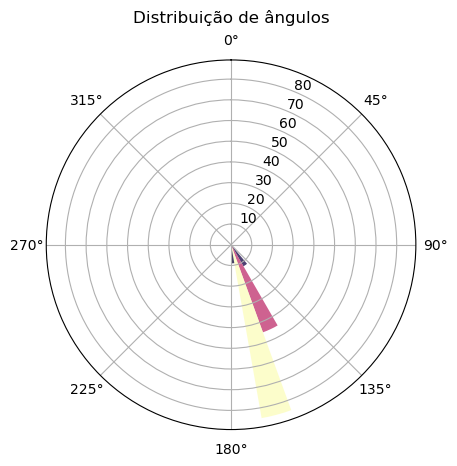

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# --- Seus Dados ---
# Supondo que você já tenha o vetor 'angles_deg'.
# Para este exemplo, vamos criar dados fictícios com uma concentração entre 90° e 180°.
np.random.seed(19680801)
angles_deg = angles_ref_animal_deg
# Garante que os ângulos fiquem no intervalo [0, 360]
angles_deg = angles_deg % 360


# --- Passo 1: Definir os Bins e Contar as Ocorrências ---
# Define o tamanho de cada "fatia" do gráfico em graus
bin_size = 10 
# Cria as bordas dos bins de 0 a 360 graus, de 10 em 10 graus
bins = np.arange(0, 361, bin_size)

# np.histogram conta quantos ângulos caem em cada bin
counts, bin_edges = np.histogram(angles_deg, bins=bins)


# --- Passo 2: Preparar os Dados para o Gráfico Polar ---
# A posição de cada barra é o centro do seu bin
bin_centers_deg = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

# Matplotlib polar usa RADIANOS, então convertemos os ângulos
theta = np.deg2rad(bin_centers_deg)

# A altura de cada barra é a contagem de ângulos no bin
radii = counts

# A largura de cada barra é o tamanho do bin em radianos
width = np.deg2rad(bin_size)

# Cores baseadas na frequência (altura da barra)
colors = plt.cm.magma(radii / np.max(radii))


# --- Passo 3: Plotar o Gráfico de Rosa ---
ax = plt.subplot(projection='polar')

# Cria as barras no gráfico polar
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.8)

# Melhora a legibilidade do gráfico (opcional)
ax.set_theta_zero_location('N')  # Coloca o 0° no topo (Norte)
ax.set_theta_direction(-1)     # Faz os ângulos crescerem no sentido horário
ax.set_title('Distribuição de ângulos', va='bottom')

plt.show()

### Plot and save

In [28]:
figures_to_save = {}

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
animal_name = 'Fidel'
condition = 'neutral can'

filename1 = f'histograma_{animal_name}_{condition}_{timestamp}.png'
filename2 = f'heatmap_{animal_name}_{condition}_{timestamp}.png'
filename3 = f'tracking_{animal_name}_{condition}_{timestamp}.png'

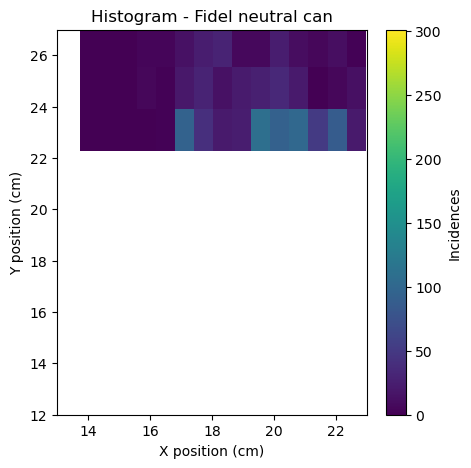

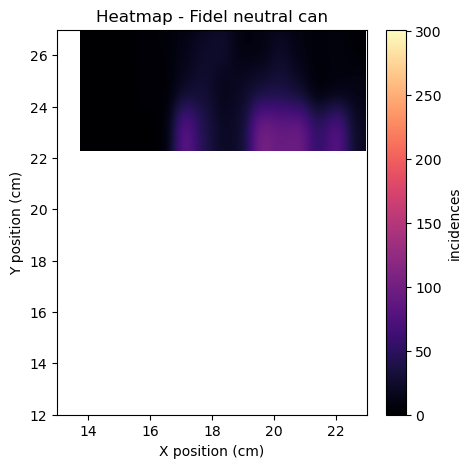

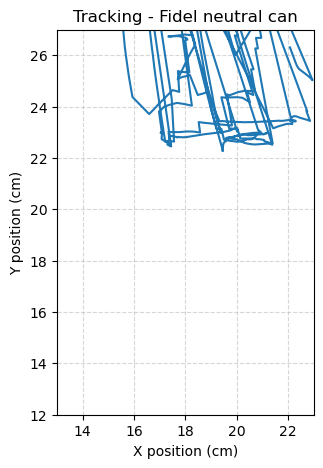

In [ ]:
xmin = 13 
xmax = 23
ymin = 27  
ymax = 12
xlim = [xmin, xmax]
ylim = [ymin, ymax]

fig1, ax1 = plt.subplots(figsize=(5, 5))
mappable = ax1.hist2d(head_x, head_y, bins=15)[3]
ax1.set_title('Histogram - ' + animal_name +' '+ condition)
ax1.set_xlabel('X position (cm)')
ax1.set_ylabel('Y position (cm)')
#ax1.set_xlim(xlim)
#ax1.set_ylim(ylim)
fig1.colorbar(mappable, ax=ax1, label='Incidences')
ax1.invert_yaxis()
figures_to_save[filename1] = fig1

fig2, ax2 = plt.subplots(figsize=(5, 5))
h, xedges, yedges = np.histogram2d(head_x, head_y, bins=15)
im = ax2.imshow(h.T, origin='lower', cmap='magma',
               interpolation='gaussian',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               aspect='auto', vmin=0, vmax=np.max(h))
fig2.colorbar(im, ax=ax2, label='incidences', orientation='vertical', shrink=1.0)
ax2.set_title('Heatmap - ' + animal_name +' '+ condition)
ax2.set_xlabel('X position (cm)')
ax2.set_ylabel('Y position (cm)')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.invert_yaxis()
figures_to_save[filename2] = fig2

fig3, ax3 = plt.subplots(figsize=(5, 5))
ax3.plot(head_x, head_y)
ax3.set_title('Tracking - ' + animal_name +' '+ condition)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.set_xlabel('X position (cm)')
ax3.set_ylabel('Y position (cm)')
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)
ax3.set_aspect('equal', adjustable='box')
ax3.invert_yaxis()
figures_to_save[filename3] = fig3

In [135]:
folder_name = animal_name +' '+ condition
os.makedirs(folder_name, exist_ok=True)

for filename, fig_object in figures_to_save.items():
        full_path = os.path.join(folder_name, filename)

        fig_object.savefig(full_path, dpi=300, bbox_inches='tight')
        print(f"- Figura '{filename}' salva com sucesso.")

- Figura 'histograma_Fidel_aversive 3D_2025-06-25_19-30.png' salva com sucesso.
- Figura 'heatmap_Fidel_aversive 3D_2025-06-25_19-30.png' salva com sucesso.
- Figura 'tracking_Fidel_aversive 3D_2025-06-25_19-30.png' salva com sucesso.
